# Small correlations and big impacts – Some back of the envelope calculations
Notebook accompanying [this blog post](https://chris-said.io/2022/05/10/social-media-and-teen-depression/).

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import pandas as pd

blue='#3ac3f2'
pink='#ed2685'
gray='#aaaaaa'
orange='#f58032'

In [4]:
path = '/Users/chrissaid/Dropbox/Blogs and Blog Material/csaid.github.io/assets/2022_teen_depression_and_social_media'

In [5]:
def rs_corr(x, baseline_scores, hours, target_r):
    # Returns the root squared difference between a candidate correlation and target correlation
    slope = x[0]
    new_scores = baseline_scores + slope * hours
    actual_r = np.corrcoef(hours, new_scores)[0,1]
    return np.sqrt((actual_r - target_r)**2)

In [70]:
def plot_bars(stats, sex, color):
    plt.figure(figsize=[6, 3.5])
    plt.bar([0], [stats[sex]['depr_rate_t1_actual']*100], color=gray)
    plt.bar([1], [stats[sex]['depr_rate_t2_actual']*100], color=color)
    plt.bar([2], [stats[sex]['depr_rate_t2_predicted']*100], color=color, alpha=0.5)
    plt.ylim([0, 25])
    plt.ylabel('Depression rate (%)', fontsize=14)
    plt.yticks(fontsize=12)
    plt.xticks([0, 1, 2], ['Pre Social Media', 'Social Media\n(Actual)', 'Social Media\n(Predicted)'], fontsize=12);
    sns.despine()
    plt.tight_layout()

In [71]:
n = 500000

#### Assumptions about hours of social media per day
My results are fairly robust to reasonable changes to the shape and size of this distribution.

In [72]:
mean_hours = 2
scale = 2
hours = np.random.gamma(scale, mean_hours/scale, size=n)

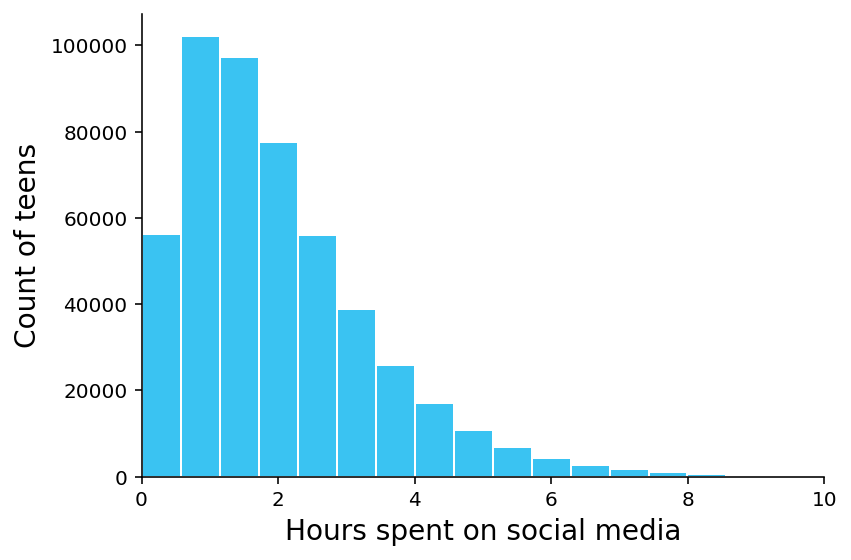

In [73]:
plt.hist(hours, bins=30, facecolor=blue, edgecolor='w');
plt.xlim([0, 10])
plt.xlabel('Hours spent on social media', fontsize=14)
plt.ylabel('Count of teens', fontsize=14)
sns.despine()
plt.tight_layout()
plt.savefig(path+'/fig_hours.png', dpi=150)

## Create well-being distributions; and fit a slope and threshold to known data

In [74]:
def get_stats(depr_rate_t1_actual, depr_rate_t2_actual, r_actual):
    scores_t1 = np.random.randn(n)
    initial_guess = -0.1
    
    # find the well-being score per hour slope that reproduces the actual correlation
    slope = minimize(rs_corr, [initial_guess], args=(scores_t1, hours, r_actual)).x[0]

    scores_t2 = scores_t1 + slope * hours
    r_reproduced = np.corrcoef(hours, scores_t2)[0,1]

    cutoff = np.percentile(scores_t1, depr_rate_t1_actual * 100)
    depr_rate_t1_predicted = (scores_t1<cutoff).mean()    
    depr_rate_t2_predicted = (scores_t2<cutoff).mean()

    assert np.isclose(r_reproduced, r_actual) # confirm I picked the right slope
    assert np.isclose(depr_rate_t1_actual, depr_rate_t1_predicted) # confirm I picked the right score cutoff

    return {
        'hours': hours,
        'scores_t1': scores_t1,
        'scores_t2': scores_t2,
        'slope': slope,
        'cutoff': cutoff,
        'depr_rate_t1_actual': depr_rate_t1_actual,
        'depr_rate_t2_actual': depr_rate_t2_actual,
        'depr_rate_t2_predicted': depr_rate_t2_predicted,
        'relative_increase_actual': depr_rate_t2_actual / depr_rate_t1_actual,
        'relative_increase_predicted': depr_rate_t2_predicted / depr_rate_t1_actual,
    }

In [75]:
stats = {}

### Girls

In [76]:
sex = 'girls'
depr_rate_t1_actual = 0.131 # Twenge (2019) Journal of Psychopathology and Clinical Science
depr_rate_t2_actual = 0.199 # Twenge (2019) Journal of Psychopathology and Clinical Science
r_actual = -0.17 # correlation reported in Twenge et al. (2020) Nature Human Behavior

In [77]:
stats[sex] = get_stats(depr_rate_t1_actual, depr_rate_t2_actual, r_actual)
print(f"Depression rates at baseline: {stats[sex]['depr_rate_t1_actual']:.3f}")
print(f"Depression rates with social media: {stats[sex]['depr_rate_t2_predicted']:.3f}")

Depression rates at baseline: 0.131
Depression rates with social media: 0.194


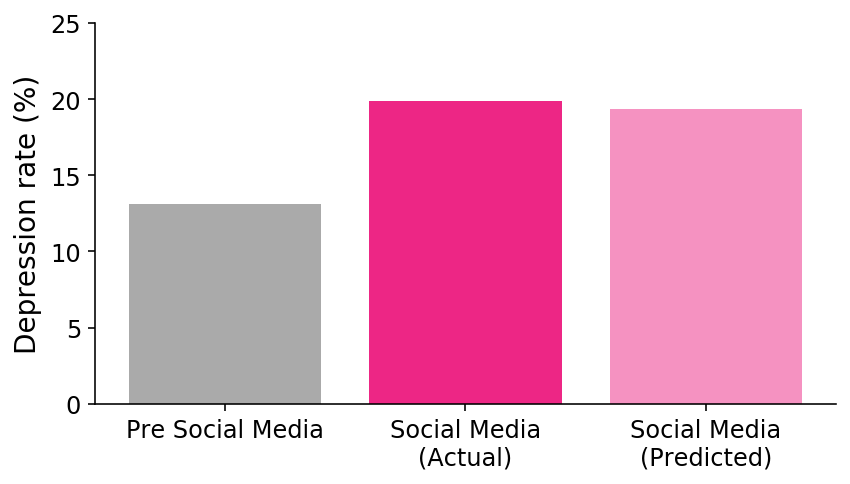

In [78]:
plot_bars(stats, 'girls', pink)
plt.savefig(path+'/fig_bars.png', dpi=150)

### Boys

In [79]:
sex = 'boys'
depr_rate_t1_actual = 0.043 # Twenge (2019) Journal of Psychopathology and Clinical Science
depr_rate_t2_actual = 0.065 # Twenge (2019) Journal of Psychopathology and Clinical Science
r_actual = -0.07 # correlation reported in Twenge et al. (2020) Nature Human Behavior

In [80]:
stats[sex] = get_stats(depr_rate_t1_actual, depr_rate_t2_actual, r_actual)
print(f"Depression rates at baseline: {stats[sex]['depr_rate_t1_actual']:.3f}")
print(f"Depression rates with social media: {stats[sex]['depr_rate_t2_predicted']:.3f}")

Depression rates at baseline: 0.043
Depression rates with social media: 0.054


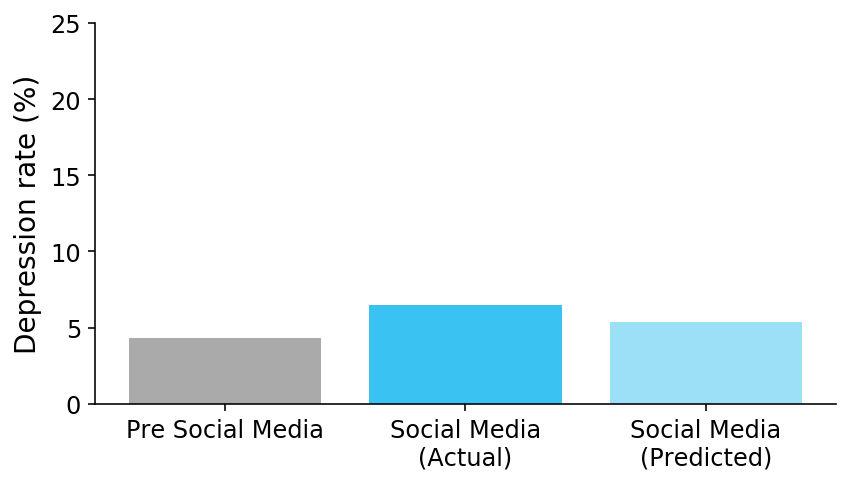

In [81]:
plot_bars(stats, 'boys', blue)

# Plots
Only showing results for girls

In [87]:
df = pd.DataFrame({
    'baseline_score': stats['girls']['scores_t1'],
    'new_score': stats['girls']['scores_t2'],
    'hours': stats['girls']['hours'],
}).sample(3000) # downsample so plots are less crowded
cutoff = stats['girls']['cutoff']


In [88]:
mx_hours = 11
mx_score = max(df['baseline_score'].max(), df['new_score'].max()) * 1.35
mn_score = min(df['baseline_score'].min(), df['new_score'].min()) * 1.05

In [89]:
def make_scatter(df, ycolumn, ylabel='Well-being', slope=0, title=' '):
    plt.scatter(df['hours'], df[ycolumn], label='Not depressed', color=gray, s=10)
    plt.scatter(df['hours'][df[ycolumn]<cutoff], df[ycolumn][df[ycolumn]<cutoff], label='Depressed', color=orange, s=10)
    plt.xlabel('Hours spent on social media', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.plot([0, mx_hours], [0, slope * mx_hours], color='k')
    plt.title(title, fontsize=20)
    plt.ylim([mn_score, mx_score]) 
    plt.xlim([plt.xlim()[0], mx_hours]) 
    plt.legend(loc='upper right')


### Side-by-side plot

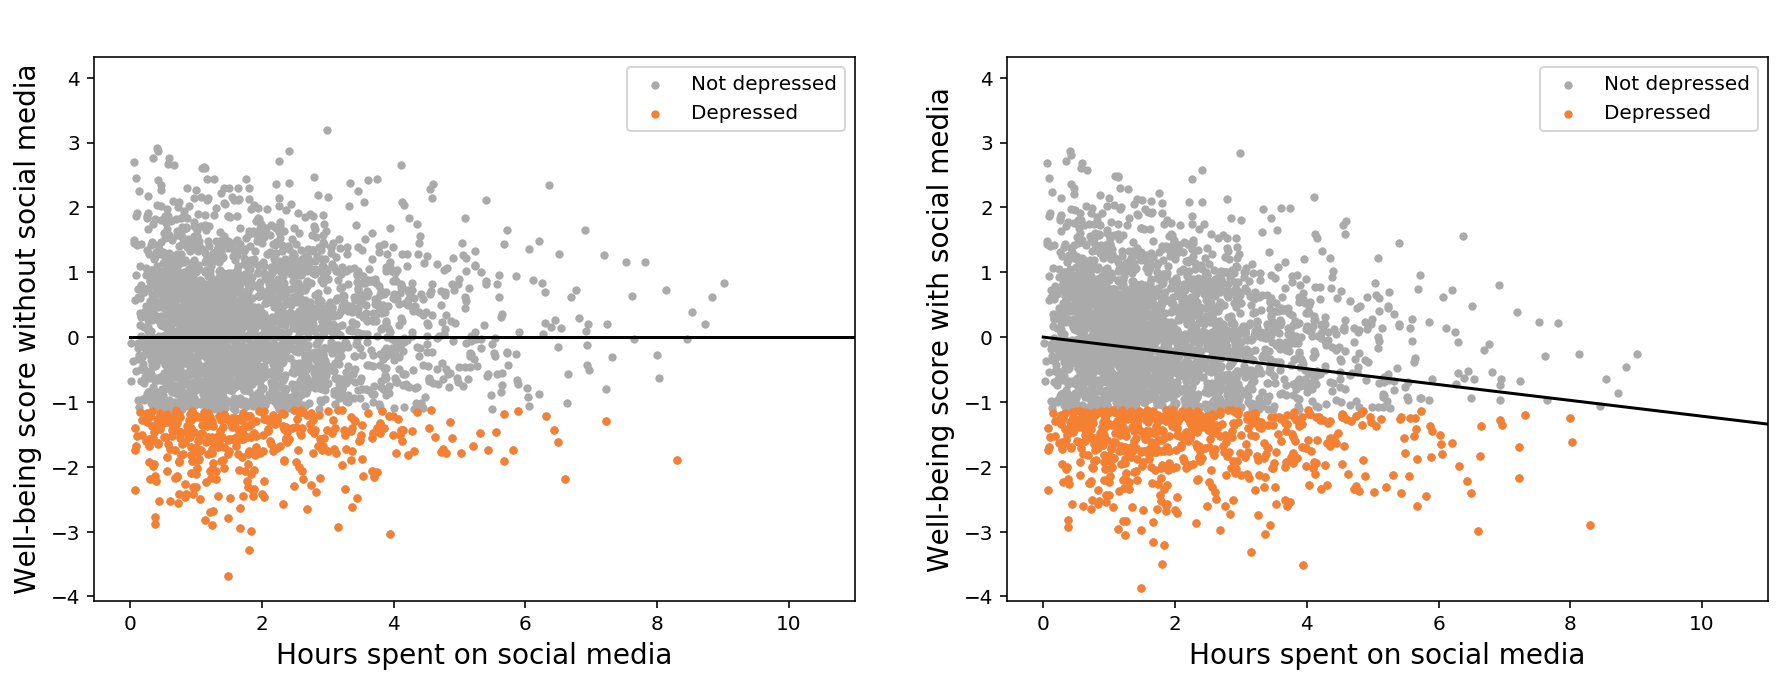

In [90]:
fig, axes = plt.subplots(1, 2, figsize=[15, 5])
plt.sca(axes[0])
make_scatter(df, 'baseline_score', ylabel='Well-being score without social media', slope=0)
plt.sca(axes[1])
make_scatter(df, 'new_score', ylabel='Well-being score with social media', slope=stats['girls']['slope'])

### Animation
Can create a GIF with ImageMagick
```
convert -delay 3 -loop 0 frames/frame*.png animation.gif
```

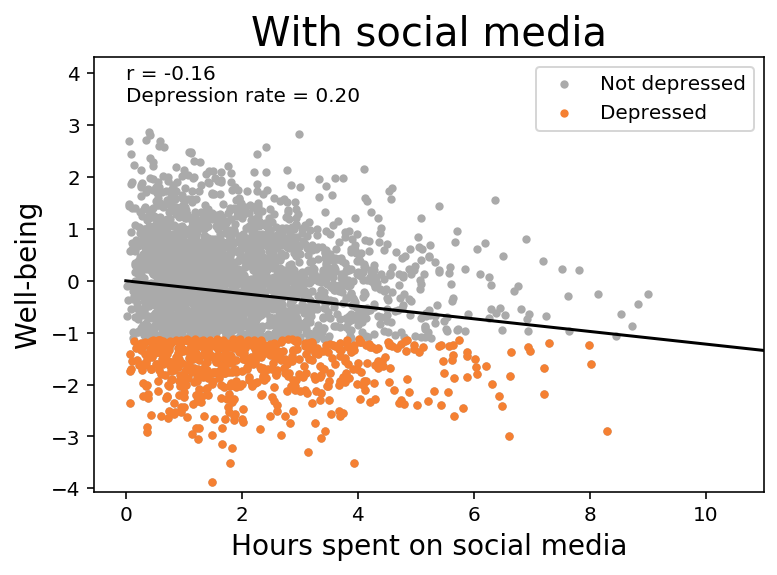

In [91]:
girls_slope = stats['girls']['slope']
slopes = np.concatenate([45*[0], np.linspace(0, girls_slope, 60), 45*[girls_slope]])
plt.figure()
for frame_idx, slope in enumerate(slopes):
    if slope == 0:
        title = 'Without social media'
    elif slope == girls_slope:
        title = 'With social media'
    else:
        title = ' '
    plt.gca().clear()
    df['new_score'] = df['baseline_score'] + slope * df['hours']
    make_scatter(df, 'new_score', ylabel='Well-being', slope=slope, title=title)
    r = df[['hours', 'new_score']].corr().loc['hours', 'new_score']
    dep_rate = (df['new_score'] < cutoff).mean()
    plt.text(0, mx_score * 0.90, f'r = {r:.2f}')
    plt.text(0, mx_score * 0.80, f'Depression rate = {dep_rate:.2f}')
    plt.savefig(f'frames/frame_{frame_idx:03d}.png', dpi=200)

### Is a 0.06% correlation small?
In case anyone asks, this would cause a 16% relative increase in depression from a 10% baseline.

In [100]:
sex = 'generic'
depr_rate_t1_actual = 0.1
depr_rate_t2_actual = 0.2
r_actual = -0.06 

In [101]:
stats[sex] = get_stats(depr_rate_t1_actual, depr_rate_t2_actual, r_actual)
print(f"Depression rates at baseline: {stats[sex]['depr_rate_t1_actual']:.3f}")
print(f"Depression rates with social media: {stats[sex]['depr_rate_t2_predicted']:.3f}")

Depression rates at baseline: 0.100
Depression rates with social media: 0.116
